In [1]:
%run nbloader.py
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import math
import numpy as np


BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

/Users/artem/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/artem/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from read_opera_bg import load_bg;
from read_opera_mc import load_mc;
pbg = load_bg(step=50);
pmc = load_mc(step=1);

importing notebook from read_opera_bg.ipynb
bg: 2767 tracks
len(slopes): 2767
importing notebook from read_opera_mc.ipynb
numtracks reduction by cuts:  [188, 186, 109, 50, 19, 19]
len(slopes): 731
bg: 546462 tracks
numtracks reduction by cuts:  [18724, 18678, 11058, 5389, 2799, 2684]


In [3]:
def alpha_creator(dmix, electron):
    dZ = 204
    
    xb = dmix[:, 0] - electron['ele_x']
    yb = dmix[:, 1] - electron['ele_y']
    zb = dmix[:, 2] - electron['ele_z']
    
    xe = dZ * electron['ele_sx']
    ye = dZ * electron['ele_sy']
    ze = dZ
    
    result = np.arccos((xb * xe + yb * ye + zb * ze)/(((xb**2 + yb**2 + zb**2)**0.5) * ((xe**2 + ye**2 + ze**2)**0.5)))
    
    dmix = np.column_stack((dmix, result))
    
    return dmix

def feature_creator(dmix, electron):
    dZ = 204
    
    xb_2 = dZ * dmix[:, 3]
    yb_2 = dZ * dmix[:, 4]
    zb_2 = dZ
    
    xe = dZ * electron['ele_sx']
    ye = dZ * electron['ele_sy']
    ze = dZ
    result = np.arccos((xb_2 * xe + yb_2 * ye + zb_2 * ze)/(((xb_2**2 + yb_2**2 + zb_2**2)**0.5) * ((xe**2 + ye**2 + ze**2)**0.5)))
    dmix = np.column_stack((dmix, result))
    
    zb = dmix[:, 2] - electron['ele_z']
    xp = dmix[:, 0]  + xb_2
    yp = dmix[:, 1]  + yb_2
    zp = dmix[:, 2] + dZ
    
    el = np.array(electron[0:3], dtype = float)
    IP_0 = np.transpose(np.array([xp, yp, zp], dtype = float))
    IP_1 = np.transpose(np.array([dmix[:, 0], dmix[:, 1], dmix[:, 2]], dtype = float))
    
    IP = np.linalg.norm(np.cross(el - IP_0, el - IP_1), axis = 1)/np.linalg.norm(IP_0 - IP_1, axis = 1)
    
    

    dmix = np.column_stack((dmix, IP / zb))
    dmix = np.column_stack((dmix, electron['ele_sx'] - dmix[:, 3]))
    dmix = np.column_stack((dmix, electron['ele_sy'] - dmix[:, 4]))
    dmix = np.column_stack((dmix, dmix[:, 2] - electron['ele_z']))
                               
    return dmix
                  


def combine_mc_bg(pmc, pbg, cone_angle = 0.05, begin = 0, end = 50):
    dZ = 204
    dmix = pd.DataFrame([
                pbg['s.eX'],
                pbg['s.eY'],
                pbg['s.eZ'],
                pbg['s.eTX'],
                pbg['s.eTY']],
                index=['b_x', 'b_y', 'b_z', 'b_sx', 'b_sy']).T
    dmix['signal'] = 0
    
    dmix = np.asarray(dmix)
    final_data = pd.DataFrame().T

    for i in range(begin ,end):
        df = pmc.iloc[i]
        d0 = pd.DataFrame([
                df['BT_X'],
                df['BT_Y'],
                df['BT_Z'] - df['BT_Z'] % 1293,
                df['BT_SX'],
                df['BT_SY']],
                index=['b_x', 'b_y', 'b_z', 'b_sx', 'b_sy']).T
        d0['signal'] = 1
        
        d0 = np.asarray(d0)
        
        data = np.concatenate((dmix, d0))
        electron = pmc.iloc[i][['ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy']]

        data = alpha_creator(data, electron)
        data = data[data[:, 6] < cone_angle, :]
        if sum(data[:, 5] == 0) != 0:                                      
            data = feature_creator(data, electron)
            data = pd.DataFrame(data, 
            columns=['b_x', 'b_y', 'b_z', 'b_sx', 'b_sy', 'signal', 'alpha', 'alpha_2', 'IP', 'd_sx', 'd_sy', 'zb'])
            data['event'] = df['Event_id']
            final_data = pd.concat([data, final_data])

    return final_data

In [4]:
from sklearn.externals import joblib
gradientBoosting = joblib.load('model9.pkl') 

In [5]:
events = combine_mc_bg(pmc, pbg, 0.09, begin = 0, end = 1000)

In [6]:
event_id_set = set(events['event'])
features = list(set(events.columns) - {'event', 'signal', 'b_x', 'b_y', 'b_z', 'b_sx', 'b_sy'})

In [7]:
x = []
y = []
for i in event_id_set:
    predict = events.loc[events['event'] == i, features]
    predict
    gbm_proba = gradientBoosting.predict_proba(predict.astype(np.float64))
    y.append(float(pmc.loc[pmc['Event_id'] == i, 'ele_P']))
    x.append(float(sum(gbm_proba[:,1] > 0.5)))

/Users/artem/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


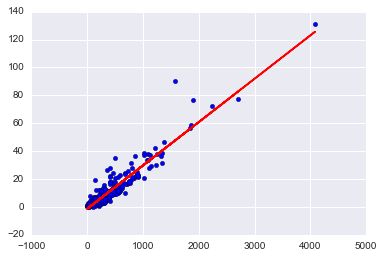

In [8]:
%matplotlib inline
x = np.array(x)
y = np.array(y)
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0]*x + fit[1], color='red')
ax.scatter(x, y)
fig.show()

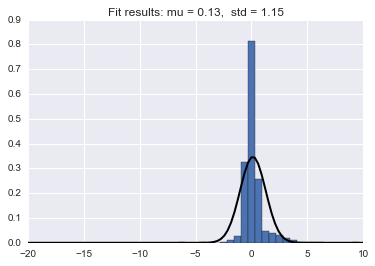

In [9]:
from scipy.stats import norm
energy_resoultion = (y - fit[0] * x- fit[1])/y
mu, std = norm.fit(energy_resoultion)
plt.hist(energy_resoultion, bins = 40, normed = True)

xmin, xmax = plt.xlim()
grid = np.linspace(xmin, xmax, 100)
p = norm.pdf(grid, mu, std)
plt.plot(grid, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [10]:
E_REC = fit[0] * x +  fit[1]
se = [[],[]]
true_and_rec = np.array([y, E_REC])

for i in range(8):
    tmp = true_and_rec[:,(E_REC < 2 * i + 2) & (E_REC >= 2*i) ]
    energy_res = np.std((tmp[0,:] - tmp[1,:])/tmp[0,:])
    print "Length of chunk: " + str(len(tmp[0,:]))
    se[0].append(energy_res)
    se[1].append(np.mean(tmp[1]))
fit_se = np.polyfit(1/np.sqrt(se[1]), se[0], deg=1)   

Length of chunk: 111
Length of chunk: 136
Length of chunk: 101
Length of chunk: 83
Length of chunk: 68
Length of chunk: 42
Length of chunk: 35
Length of chunk: 17


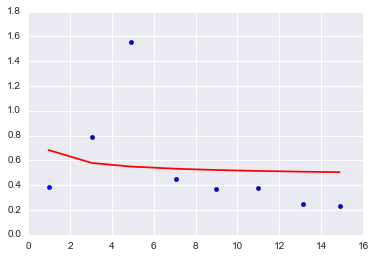

In [11]:
fig, ax = plt.subplots()
ax.plot(se[1], fit_se[0]/np.sqrt(se[1]) + fit_se[1], color='red')
ax.scatter(se[1], se[0])
fig.show()